In [81]:
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.signal import windows

import utils

# Applying a Hann-Window to ALOS-PALSAR L1.1 Data

## 1. Read the complex SLC data

In [40]:
product_path = Path("/home/debian/data_share/alos_palsar/ALPSRP139670660-H1.1__A")
fname = "IMG-HH-ALPSRP139670660-H1.1__A"

slc = utils.read_alospalsar_image(product_path/fname)
n_lines = slc.shape[0]
n_pixels = slc.shape[1]

# 2. Create an overview image 

Create logarithmic intensity (power) image.

In [9]:
slc_intensity_dB = 20 * np.log10(np.abs(slc))

Visualize intensity image.

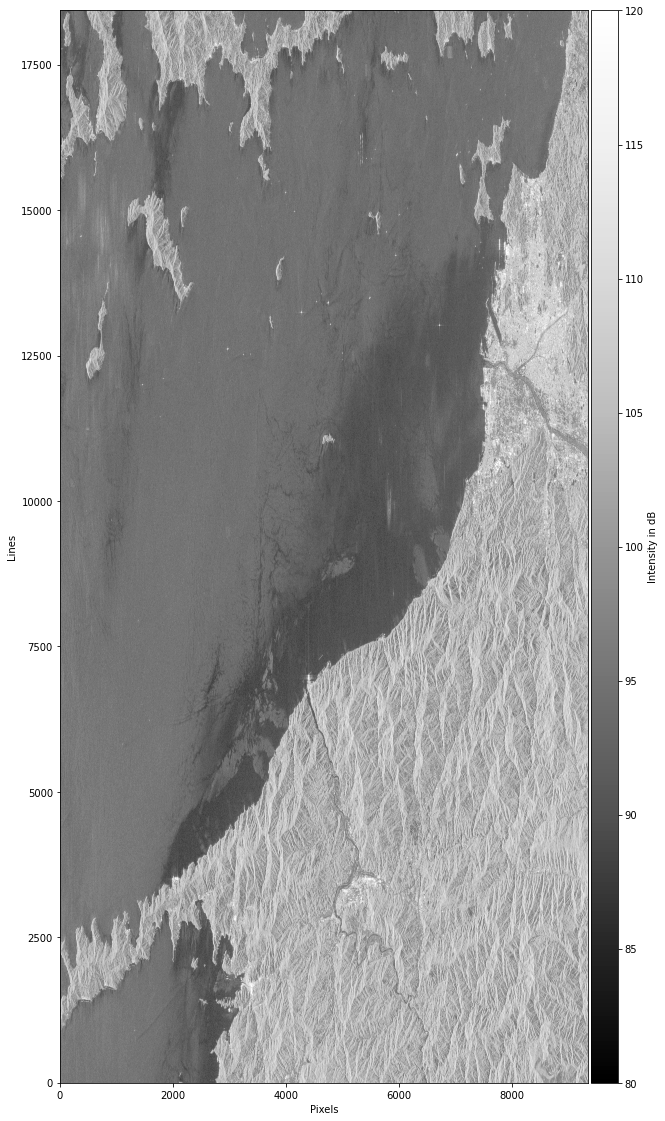

In [43]:
scale = 10

fig, ax = plt.subplots(1, 1, figsize = (scale, scale * n_lines/n_pixels))

img = ax.imshow(slc_intensity_dB,
          origin = "lower",
          vmin = 80,
          vmax = 120,
          cmap="Greys_r",
          aspect='auto',
         )

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(img, cax=cax, label="Intensity in dB")

# 3. Implement frequency based windowing

## 3.1 For each line, compute the Fourier transform with a size of 16384

Numpy's fft function offers the possibility to compute the FFT for all lines (`axis=1`)

In [105]:
n_fft = 16384
slc_fft = np.fft.fftshift(np.fft.fft(slc, n = n_fft, axis = 1), axes=1)

Visualize the line spectra

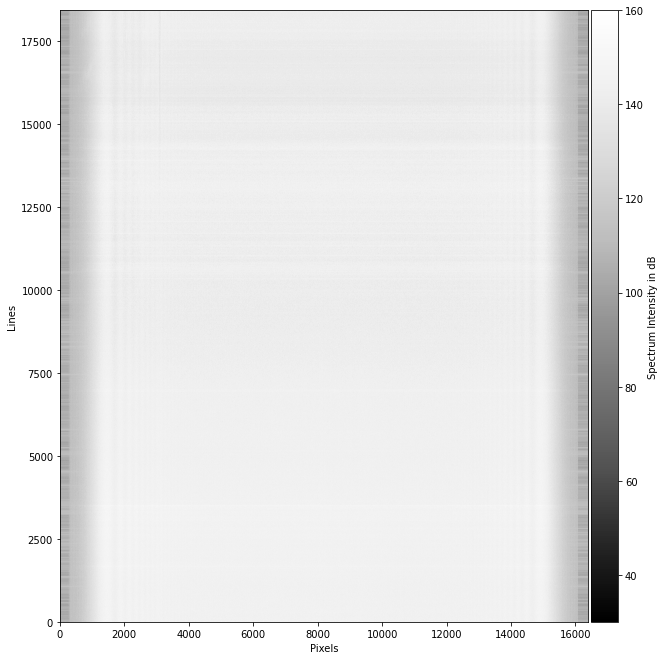

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (scale, scale * n_lines/n_fft))

slc_fft_dB = 20 * np.log10(np.abs(slc_fft))
img = ax.imshow(slc_fft_dB,
          origin = "lower",
          cmap="Greys_r",
          vmin = 30,
          vmax = 160,
          aspect='auto',
         )

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(img, cax=cax, label="Spectrum Intensity in dB")

## 3.2 Apply the Hanning window to the central part of the frequency spectrum

Comput Hann-window using `scipy`

In [92]:
n_hann = int(n_fft/2)

ind_hann_start = 4096
ind_hann_end = ind_hann_start + n_hann

hann_window = np.zeros(n_fft)
hann_window[ind_hann_start:ind_hann_end] = windows.hann(n_hann)

Plot Hann-window

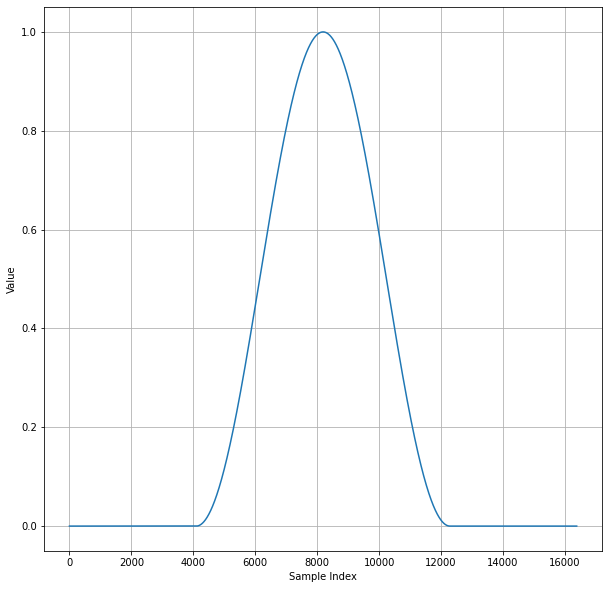

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(scale*1, scale*1))

ax.plot(hann_window)
ax.grid(True)

ax.set_xlabel("Sample Index")
ax.set_ylabel("Value")

plt.xticks(np.arange(0, n_fft, 2000));

Apply Hann-window to the range spectra

In [108]:
slc_fft_filtered = slc_fft * hann_window[None, :]

Visualize spectra after application of Hann-window

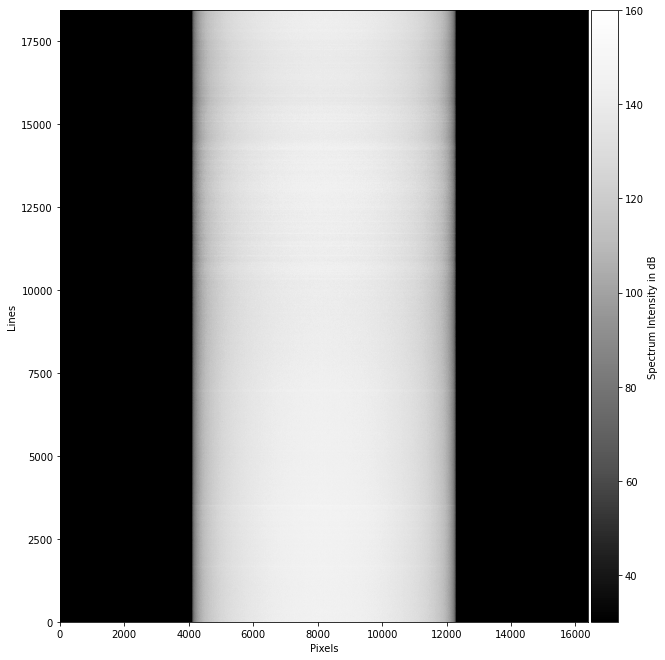

In [103]:
fig, ax = plt.subplots(1, 1, figsize = (scale, scale * n_lines/n_fft))

slc_fft_dB = 20 * np.log10(np.abs(slc_fft), where=(slc_fft!=0))

img = ax.imshow(slc_fft_dB,
          origin = "lower",
          cmap="Greys_r",
          vmin = 30,
          vmax = 160,
          aspect='auto',
         )

ax.set_ylabel("Lines")
ax.set_xlabel("Pixels")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(img, cax=cax, label="Spectrum Intensity in dB")

## 3.3 Compute Inverser Fourier Transform

In [109]:
slc_filtered = np.fft.ifft(np.fft.fftshift(slc_fft_filtered))
slc_filtered = slc_filtered[:, :n_pixels]